In [30]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32
test_batch_size = 1000
epochs = 10
lr = 0.01
momentum = 0.5
no_cuda = False
seed = 1
log_interval = 10

cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

if cuda:
    torch.cuda.manual_seed(seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)


class MLPNetModified(nn.Module):
    def __init__(self, f1, f2, f3):
        super(MLPNetModified, self).__init__()
        self.f1 = f1
        self.f2 = f2
        self.f3 = f3
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.f1(x)
        x = self.fc2(x)
        x = self.f2(x)
        x = self.fc3(x)
        x = self.f3(x)
        return F.log_softmax(x)
    def name(self):
        return 'mlpnet'

plots_test_loss = []
plots_train_loss = []
plots_test_accuracy = []
epoch_model_parameters = []

def solve(f1, f2, f3):
    layers = str(f1).split()[1]+"_"+str(f2).split()[1]+"_"+str(f3).split()[1]
    print (layers)
    model = MLPNetModified(f1, f2, f3)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    train_loss = []
    test_losses = []
    test_accuracy = []
    train_max_values = []
    def train(epoch):
        model.train()
        loss_to_print = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            loss_to_print = loss.data[0]
            if batch_idx % log_interval == 0:
                train_loss.append(loss.data[0])
        print (epoch, loss_to_print)
        params=model.state_dict()
        train_max_values.append([torch.max(params['fc1.weight']), torch.max(params['fc2.weight']), torch.max(params['fc3.weight'])])
        return train_max_values
    def test(epoch):
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracy.append(100. * correct / len(test_loader.dataset))
        if (epoch == epochs):
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))
    for epoch in range(1, epochs + 1):
        train_max_values = train(epoch)
        test(epoch)
    return train_max_values,layers

paramA = solve(F.relu, F.relu, F.relu)
paramB = solve(F.relu, F.sigmoid, F.relu)
paramC = solve(F.relu, F.sigmoid, F.tanh)

test_accuracy_last = []

for a in plots_test_accuracy:
    test_accuracy_last.append(['_'.join(a[0].split('_')[0:3]), a[1][len(a[1]) - 1]])


test_accuracy_last.sort(key=lambda x: x[1])
for a in test_accuracy_last:
    print(a)

arr0 = np.array(paramA[0])
arr1 = np.array(paramB[0])
arr2 = np.array(paramC[0])
plt.figure()
plt.plot(arr0[:,0],label=paramA[1])
plt.plot(arr1[:,0],label=paramB[1])
plt.plot(arr2[:,0],label=paramC[1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig("max_weights_per_iteration/"+str(epochs)+"_iterations.png")

relu_relu_relu
1 0.13197508454322815
2 0.061797771602869034
3 0.047406766563653946
4 0.04274652153253555
5 0.07503548264503479
6 0.031121335923671722
7 0.0016826121136546135
8 0.04030686616897583
9 0.03174635022878647
10 0.0027607083320617676

Test set: Average loss: 0.0619, Accuracy: 9795/10000 (98%)

relu_sigmoid_relu
1 1.5898154973983765
2 1.1462095975875854
3 1.1316478252410889
4 0.6600117087364197
5 0.6857587695121765
6 0.7237051725387573
7 0.612843930721283
8 0.8079507946968079
9 0.6040196418762207
10 0.8599200248718262

Test set: Average loss: 0.7589, Accuracy: 7825/10000 (78%)

relu_sigmoid_tanh
1 1.034830093383789
2 1.0283654928207397
3 0.9301056265830994
4 0.869178295135498
5 0.9020575284957886
6 0.8179965615272522
7 0.8151505589485168
8 0.8926700949668884
9 0.9116194248199463
10 0.8165391087532043

Test set: Average loss: 0.8809, Accuracy: 9566/10000 (96%)



In [33]:
arr0 = np.array(paramA[0])
arr1 = np.array(paramB[0])
arr2 = np.array(paramC[0])
plt.figure()
plt.plot(arr0[:,0],label=paramA[1])
plt.plot(arr1[:,0],label=paramB[1])
plt.plot(arr2[:,0],label=paramC[1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig("max_weights_per_iteration/"+str(epochs)+"_iterations.png")

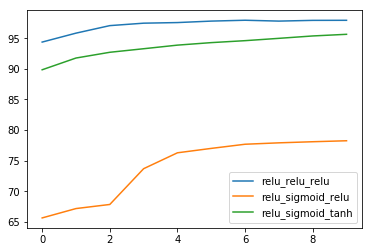

In [213]:
import numpy as np


plt.figure()
for a in plots_test_accuracy:
    if ('relu' in a[0]):
        plt.plot(a[1], label='_'.join(a[0].split('_')[0:3]))
        plt.legend(loc='lower right')
plt.show()

In [7]:
print(torch.max(paramA['fc1.weight'],1))

(
 0.0501
 0.0573
 0.0494
 0.0539
 0.0743
 0.0437
 0.0778
 0.0690
 0.0493
 0.0926
 0.0577
 0.0486
 0.0442
 0.0539
 0.0670
 0.0569
 0.0786
 0.0643
 0.0536
 0.0579
 0.0803
 0.0397
 0.0963
 0.0633
 0.1045
 0.0627
 0.0817
 0.0521
 0.0887
 0.0602
 0.0469
 0.0691
 0.0788
 0.0836
 0.0531
 0.0536
 0.0683
 0.0656
 0.1011
 0.0680
 0.0573
 0.0566
 0.0827
 0.0579
 0.0496
 0.0549
 0.0782
 0.0761
 0.0505
 0.0792
 0.0456
 0.0363
 0.0745
 0.0515
 0.0744
 0.0633
 0.0796
 0.0913
 0.0547
 0.0463
 0.0526
 0.0476
 0.0451
 0.0743
 0.0516
 0.0488
 0.0567
 0.0384
 0.0560
 0.0675
 0.0468
 0.0575
 0.0421
 0.0797
 0.0689
 0.0536
 0.0503
 0.0523
 0.0643
 0.0581
 0.0600
 0.0715
 0.0444
 0.0759
 0.0550
 0.0466
 0.0502
 0.0364
 0.0492
 0.0507
 0.0381
 0.0637
 0.0580
 0.0589
 0.0568
 0.0735
 0.0601
 0.0460
 0.0551
 0.0625
 0.0526
 0.0679
 0.0618
 0.0678
 0.0853
 0.0594
 0.0656
 0.0600
 0.0896
 0.0844
 0.0708
 0.0796
 0.0836
 0.0486
 0.0629
 0.0515
 0.0515
 0.0581
 0.0541
 0.0495
 0.0758
 0.0823
 0.0534
 0.0725
 0.066

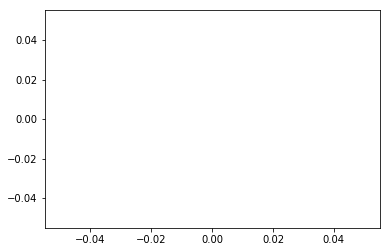

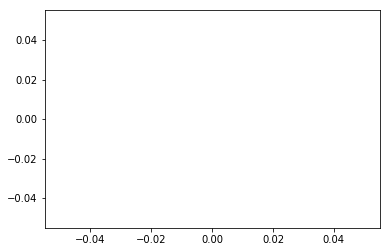

-------------------


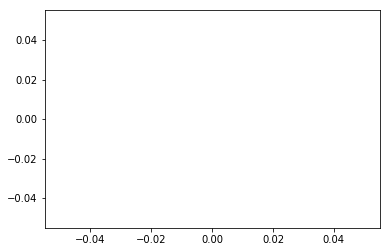

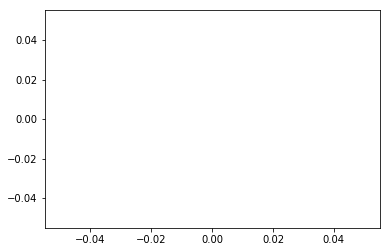

-------------------


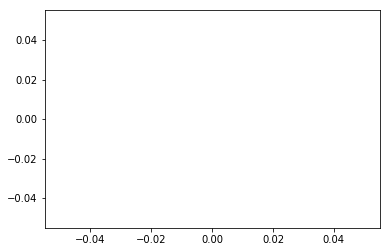

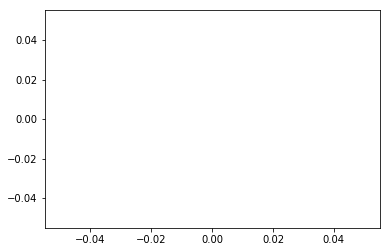

-------------------


In [138]:
for model in epoch_model_parameters:
    for epoch_params in model[1]:
        weights=[]
        biases=[]
        plt.figure()
        for iter in epoch_params:
            weights.append(list(iter[0][0][0]))
            biases.append(list(iter[1][0]))
        plt.plot(weights,label="(0,0)link-weights")
        plt.plot(biases,label="(0)link-weights")
        plt.show()
    print("-------------------")

-------------------
-------------------
-------------------


Variable containing:
1.00000e-02 *
 -3.1352
 -1.6746
  3.2839
  1.8430
  2.7006
 -3.1914
 -1.5613
  1.5349
  2.0595
  1.8095
  0.0236
  2.2531
 -3.6852
 -0.7068
 -1.6062
  1.2018
  1.8611
 -0.6121
 -2.1561
  1.9647
 -2.9125
  2.9778
 -2.5717
 -2.3797
  1.7421
  1.4048
 -2.4227
  1.7237
 -1.9722
 -1.3200
 -1.1590
 -0.3558
  1.5895
  3.0110
  0.2436
  0.8217
 -3.7511
  1.6879
  0.4498
  3.3325
 -3.3983
 -1.8089
 -0.6596
  0.5617
  3.1159
 -2.0265
 -3.0013
  0.7838
 -1.5298
  0.3445
 -3.6580
  0.7016
 -0.7279
  0.9497
 -3.7447
 -2.3340
 -1.8218
  1.6390
  2.1099
 -2.7865
 -2.1359
  2.8904
 -2.4039
  2.6115
  1.4272
  1.0265
 -0.6166
  2.1381
 -1.8333
 -3.1747
  1.5453
 -0.1170
  1.7992
  2.5682
 -1.1918
 -3.3847
 -1.3797
  1.7310
 -3.1008
 -1.3886
  0.1050
  1.2576
  0.6932
 -0.8649
 -2.8967
 -0.6849
 -2.6331
 -3.4623
 -3.0858
 -2.3788
  0.0545
  3.0374
 -2.5028
 -0.4102
 -0.2474
  0.1953
 -3.0121
 -3.3229
 -4.1810
 -0.9677
 -4.2583
 -1.9362
 -0.1845
  0.2063
 -3.1746
  1.8992
 -1.3200
 -

AttributeError: 'list' object has no attribute 'parameters'